## Import the required libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Read the data

**companies** - the dataframe containing information of the startups \
**rounds2** - the dataframe containing the information about each round of investments done in the companies \
**mapping** - maping of industry and the categories \

There seems to be difference in the encoding of companies and round2 files. The default encoding used by read_csv method of pandas resulted in character differences in companies and round2 dataframes. After trying "mac_roman" and "Latin-1/iso-8859-1", the later seems to work better.

In [2]:
companies = pd.read_csv('companies.csv', encoding='iso-8859-1')
rounds2 = pd.read_csv('rounds2.csv', encoding='iso-8859-1')
mapping = pd.read_csv('mapping.csv', encoding='iso-8859-1')

## Describe the datasets

In [3]:
companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66368 entries, 0 to 66367
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   permalink      66368 non-null  object
 1   name           66367 non-null  object
 2   homepage_url   61310 non-null  object
 3   category_list  63220 non-null  object
 4   status         66368 non-null  object
 5   country_code   59410 non-null  object
 6   state_code     57821 non-null  object
 7   region         58338 non-null  object
 8   city           58340 non-null  object
 9   founded_at     51147 non-null  object
dtypes: object(10)
memory usage: 5.1+ MB


In [4]:
rounds2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114949 entries, 0 to 114948
Data columns (total 6 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   company_permalink        114949 non-null  object 
 1   funding_round_permalink  114949 non-null  object 
 2   funding_round_type       114949 non-null  object 
 3   funding_round_code       31140 non-null   object 
 4   funded_at                114949 non-null  object 
 5   raised_amount_usd        94959 non-null   float64
dtypes: float64(1), object(5)
memory usage: 5.3+ MB


In [5]:
print('companies dataframe shape -',companies.shape)
print('rounds2 dataframe shape -', rounds2.shape)

companies dataframe shape - (66368, 10)
rounds2 dataframe shape - (114949, 6)


In [6]:
companies['permalink'] = companies['permalink'].str.encode('ascii', 'ignore').str.decode('ascii')
companies['name'] = companies['name'].str.encode('ascii', 'ignore').str.decode('ascii')
rounds2['company_permalink'] = rounds2['company_permalink'].str.encode('ascii', 'ignore').str.decode('ascii')

## Checkpoint 1: Data Cleaning 1
Check for null, missing values in each dataframe.
### companies 
The dataframe has maximum number of null values in column founded_at followed by state_code, region, city, country_code, homepage_url and category_list.

In [7]:
companies.isnull().sum(axis=0)

permalink            0
name                 1
homepage_url      5058
category_list     3148
status               0
country_code      6958
state_code        8547
region            8030
city              8028
founded_at       15221
dtype: int64

Lets calculate the percentage of null values in companies dataframe

In [8]:
100*companies.isnull().sum()/len(companies.index)

permalink         0.000000
name              0.001507
homepage_url      7.621143
category_list     4.743250
status            0.000000
country_code     10.483968
state_code       12.878194
region           12.099204
city             12.096191
founded_at       22.934245
dtype: float64

From the columns with high null values country_code and category_list are important for our analysis. We can drop after merging the two datasets. We will drop after merging the datasets because we want to keep the original data in tact. \
### rounds2
Now lets calculate the same for rounds2 dataset.

In [10]:
100*rounds2.isnull().sum(axis=0)/len(rounds2.index)

company_permalink           0.000000
funding_round_permalink     0.000000
funding_round_type          0.000000
funding_round_code         72.909725
funded_at                   0.000000
raised_amount_usd          17.390321
dtype: float64

In rounds2 dataset two cloumns - funding_round_code and raised_amount_usd have high percentage of null values. Out of these two columns only raised_amount_usd is important for our analysis so we can drop funding_round_code column. We can tackle null values in raised_amount_usd in two ways 
1. remove the rows with null value
2. fill the null with median value for the funding type

We will do this after merging the datasets.

The permalink column in companies dataframe and company_permalink in rounds2 dataframe have case discripency. We will convert everything in lower case. Also rename the company_permalink to permalink because later the merge is performed on this column.

In [11]:
rounds2.rename(columns={'company_permalink':'permalink'}, inplace=True)

In [12]:
to_lower_case = lambda x: x.lower()

companies['permalink'] = companies.permalink.apply(to_lower_case)
rounds2['permalink'] = rounds2.permalink.apply(to_lower_case)

In [13]:
companies.permalink.describe()

count                     66368
unique                    66368
top       /organization/wide-io
freq                          1
Name: permalink, dtype: object

In [14]:
rounds2.permalink.describe()

count                       114949
unique                       66368
top       /organization/solarflare
freq                            19
Name: permalink, dtype: object

Create index on permalink columns of companies and round2 dataframes.

In [15]:
companies.set_index('permalink', inplace=True)
rounds2.set_index('permalink', inplace=True)

We can take set difference between the columns of two dataframes to figure out the companies which are present in rounds2 dataframe but not in companies.

In [16]:
len(set(rounds2.index) - set(companies.index))

0

So there are 7 companies in rounds2 dataframe which are not present in companies dataframe.

In [17]:
master_frame = pd.merge(companies, rounds2, how='inner', on='permalink')

In [18]:
print('master_frame shape -', master_frame.shape)

master_frame shape - (114949, 14)


### Drop the columns with null values
As discssed earlier lets drop the columns
- homepage_url
- state_code
- region
- city
- founded_at
- funding_round_code

In [19]:
master_frame = master_frame.drop(['homepage_url', 'state_code', 'region', 'city', 'founded_at', 'funding_round_code'], axis=1)

In [20]:
master_frame.isnull().sum()

name                           1
category_list               3410
status                         0
country_code                8678
funding_round_permalink        0
funding_round_type             0
funded_at                      0
raised_amount_usd          19990
dtype: int64

In [21]:
100*master_frame.isnull().sum()/len(master_frame.index)

name                        0.000870
category_list               2.966533
status                      0.000000
country_code                7.549435
funding_round_permalink     0.000000
funding_round_type          0.000000
funded_at                   0.000000
raised_amount_usd          17.390321
dtype: float64

### Drop rows with null data
Now lets remove the rows containing raised_funding_usd as null. 

In [22]:
master_frame[master_frame.raised_amount_usd.isnull()]

,name,category_list,status,country_code,funding_round_permalink,funding_round_type,funded_at,raised_amount_usd
permalink,,,,,,,,
/organization/-qounter,:Qounter,Application Platforms|Real Time|Social Network...,operating,USA,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,14-10-2014,NaN
/organization/004-technologies,004 Technologies,Software,operating,USA,/funding-round/1278dd4e6a37fa4b7d7e06c21b3c1830,venture,24-07-2014,NaN
/organization/1,One Inc.,Mobile,operating,USA,/funding-round/5de6d8828aef7d925d97918d15727670,undisclosed,05-02-2013,NaN
/organization/1-4-all,1-4 All,Entertainment|Games|Software,operating,USA,/funding-round/e97a192e13ea0ee3c4f71136b4f3ec16,equity_crowdfunding,21-04-2013,NaN
/organization/1-618-technology,1.618 Technology,Networking|Real Estate|Web Hosting,operating,USA,/funding-round/83b8f4c7d37ecef5e001a5e953bf461a,equity_crowdfunding,22-01-2014,NaN
...,...,...,...,...,...,...,...,...
/organization/zymr-inc-,"Zymr, Inc.",Android|Apps|Cloud Computing|Cloud Infrastruct...,operating,USA,/funding-round/9048d1a80edeae803ed1790c9f473eec,angel,12-12-2012,NaN
/organization/zynergy-projects-services,Zynergy Projects & Services,Clean Technology,operating,IND,/funding-round/3d7dbd2d92220d93e2b5455f914a0918,venture,19-08-2015,NaN
/organization/zynga,Zynga,Facebook Applications|Games|Networking|Technology,ipo,USA,/funding-round/d27f10a20b15b4ef3d9961d54eabf6b1,angel,01-01-2007,NaN


In [23]:
master_frame.groupby('funding_round_type').raised_amount_usd.describe()

,count,mean,std,min,25%,50%,75%,max
funding_round_type,,,,,,,,
angel,4860.0,9.586945e+05,7.404397e+06,0.0,150000.00,400000.0,1000000.0,4.945120e+08
convertible_note,1447.0,1.453439e+06,8.043846e+06,0.0,78847.50,272000.0,1000000.0,1.850483e+08
debt_financing,6682.0,1.704353e+07,2.803204e+08,0.0,330484.25,1100000.0,4000000.0,2.127194e+10
equity_crowdfunding,1228.0,5.383682e+05,1.719329e+06,0.0,7000.00,100000.0,395901.0,2.740000e+07
grant,2124.0,4.300576e+06,2.558742e+07,0.0,50000.00,201684.0,1700000.0,7.500000e+08
non_equity_assistance,73.0,4.112031e+05,1.771747e+06,0.0,25000.00,60000.0,125000.0,1.500000e+07
post_ipo_debt,152.0,1.687046e+08,6.024738e+08,70000.0,4000000.00,19950000.0,60000000.0,5.800000e+09
post_ipo_equity,628.0,8.218249e+07,4.691889e+08,77.0,3764794.00,12262852.5,40000000.0,1.066494e+10
private_equity,1936.0,7.330859e+07,1.981135e+08,0.0,5000000.00,20000000.0,75000000.0,4.745460e+09


In [24]:
master_frame['raised_amount_usd'] = master_frame.apply(
    lambda row: 275000 if ((np.isnan(row['raised_amount_usd'])) & (row['funding_round_type'] == 'seed')) else row['raised_amount_usd'], axis=1)

In [25]:
master_frame['raised_amount_usd'] = master_frame.apply(
    lambda row: 5000000 if ((np.isnan(row['raised_amount_usd'])) & (row['funding_round_type'] == 'venture')) else row['raised_amount_usd'], axis=1)

In [26]:
master_frame['raised_amount_usd'] = master_frame.apply(
    lambda row: 20000000 if ((np.isnan(row['raised_amount_usd'])) & (row['funding_round_type'] == 'private_equity')) else row['raised_amount_usd'], axis=1)

In [27]:
master_frame['raised_amount_usd'] = master_frame.apply(
    lambda row: 400000 if ((np.isnan(row['raised_amount_usd'])) & (row['funding_round_type'] == 'angel')) else row['raised_amount_usd'], axis=1)

In [28]:
master_frame = master_frame[~master_frame.raised_amount_usd.isnull()]

In [29]:
100*master_frame.isnull().sum()/len(master_frame.index)

name                       0.000920
category_list              2.470362
status                     0.000000
country_code               7.496620
funding_round_permalink    0.000000
funding_round_type         0.000000
funded_at                  0.000000
raised_amount_usd          0.000000
dtype: float64

In [30]:
print('master_frame shape after removing rows with null raised_funding_usd -', master_frame.shape)

master_frame shape after removing rows with null raised_funding_usd - (108729, 8)


Now lets analyse the country_code as its important column for our analysis.

In [31]:
master_frame.country_code.describe()

count     100578
unique       137
top          USA
freq       68318
Name: country_code, dtype: object

USA is the highest occuring country and there are 134 unique contry codes. Now lets calculate the percentage to understand the distribution properly.

In [32]:
100*master_frame.country_code.value_counts()/len(master_frame.index)

USA    62.833283
GBR     5.235954
CAN     2.641430
CHN     2.348959
IND     1.966357
         ...    
JEY     0.000920
TGO     0.000920
MNE     0.000920
DMA     0.000920
GRD     0.000920
Name: country_code, Length: 137, dtype: float64

In [33]:
master_frame.country_code.isnull().sum()

8151

One thing we can do is to check if city column is available for records with country_code as null and use it to infer the country code. However as we have already dropped city column and the number of rows with country_code as null is about 6% of total data, we can drop the rows.

In [34]:
master_frame = master_frame[~master_frame.country_code.isna()]

In [35]:
100*master_frame.isnull().sum()/len(master_frame.index)

name                       0.000994
category_list              1.231880
status                     0.000000
country_code               0.000000
funding_round_permalink    0.000000
funding_round_type         0.000000
funded_at                  0.000000
raised_amount_usd          0.000000
dtype: float64

We can drop the records with category_list as null as its just 0.65% of total data. There are also very small number of records with name as null but we can live with it. 

In [36]:
master_frame = master_frame[~master_frame.category_list.isnull()]

In [37]:
100*master_frame.isnull().sum()/len(master_frame.index)

name                       0.001007
category_list              0.000000
status                     0.000000
country_code               0.000000
funding_round_permalink    0.000000
funding_round_type         0.000000
funded_at                  0.000000
raised_amount_usd          0.000000
dtype: float64

In [38]:
master_frame.reset_index(inplace=True)

In [39]:
master_frame.shape

(99339, 9)

**End of Checkpoint 1: Data Cleaning 1**

------------------------------------------------------------

## Checkpoint 2: Funding Type Analysis

Now lets focus on the funding type analysis. The Spark Funds wants to 
- choose one of the 4 investment types 
  - venture
  - angel
  - seed
  - private equity
- invest between 5 to 15 million USD per investment round

Lets start by describing the raised_amount_usd column

In [40]:
master_frame.raised_amount_usd.describe()

count    9.933900e+04
mean     9.612444e+06
std      1.055879e+08
min      0.000000e+00
25%      2.755325e+05
50%      1.650000e+06
75%      6.000000e+06
max      2.127194e+10
Name: raised_amount_usd, dtype: float64

There is huge difference between the min and max values. The mean is at about ~10 million which is more than the 75th quartile which is at about ~7 million.
Lets try to focus on the data pertaining to the four types of investment types and compare the mean, median numbers.

In [41]:
inv_types = [tuple(i) for i in ['angel', 'venture', 'seed', 'private_equity']]
master_frame = master_frame[master_frame['funding_round_type'].apply(tuple).isin(inv_types)]

In [42]:
master_frame.funding_round_type.value_counts()

venture           52024
seed              26438
angel              5417
private_equity     2055
Name: funding_round_type, dtype: int64

In [43]:
master_frame.raised_amount_usd.describe()

count    8.593400e+04
mean     8.643752e+06
std      7.290849e+07
min      0.000000e+00
25%      3.153850e+05
50%      2.000000e+06
75%      6.588200e+06
max      1.760000e+10
Name: raised_amount_usd, dtype: float64

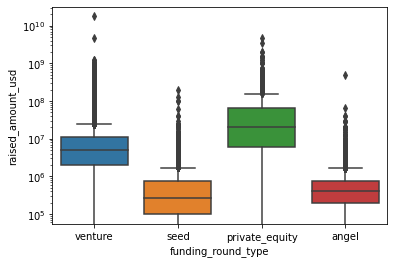

In [44]:
sns.boxplot(y=master_frame['raised_amount_usd'], x=master_frame['funding_round_type'])
plt.yscale('log')
plt.show()

Create a pivote table of funding type and the median amount invested. We choose median amount to ignore the outliers.

In [45]:
pd.pivot_table(data=master_frame, columns='funding_round_type', values='raised_amount_usd', aggfunc=[np.median, np.mean])

median                                      \
funding_round_type     angel private_equity      seed    venture   
raised_amount_usd   400000.0     20000000.0  275000.0  5000000.0   

                            mean                                              
funding_round_type         angel private_equity           seed       venture  
raised_amount_usd   864265.29832   6.777034e+07  652244.221651  1.117942e+07

As we can see that there is big difference between mean and median for each type of funding and from the boxplot we can see that there are outliers for each funding type we should consider median as representative value for funding types. 

From the boxplot 
- the median of venture funding is 5 million and the mean is ~11.7 million. Both these numbers are within the targeted investment amount of Spark Funds.
- the median of seed funding is 300000 and the mean is ~747793. Both these numbers are way below the desired investment amount of Spark Funds
- the median of angel funding is 414906 and the mean is ~971573. Again both these numbers are less than the Spark Funds targeted investment amount
- the median of private equity is 20 million and the mean is ~73.93 million. Both these amounts are more than the Spark Funds investment targets

**The venture investment type should be considered by Spark Funds.**

## End of Checkpoint 2: Funding Type Analysis

------------------------------------------------------------------------------------

## Checkpoint 3: Country Analysis

Spark Funds wants to invest in 
- countries with highest funding received in venture type
- English speaking countries

Lets group the data for venture type investment by country. Aggregating the funding values across all these countries and sorting it in descending order will give us top9 counties. 

In [46]:
groupby_country = master_frame[master_frame.funding_round_type == 'venture'].groupby(by='country_code')

Lets capture the top9 country codes in a variable which we will use later to filter the data.

In [47]:
top9_country_codes = groupby_country.raised_amount_usd.sum().sort_values(ascending=False).head(9).index

Filter the data using top9 country codes. 

In [48]:
top9_country_codes = [tuple(i) for i in top9_country_codes.values]
top9 = master_frame[master_frame['country_code'].apply(tuple).isin(top9_country_codes)]

As we are interested in venture investment type data, filter it by funding_round_type

In [49]:
top9 = top9[top9.funding_round_type == 'venture']

In [50]:
top9.country_code.value_counts()

USA    38034
GBR     2265
CHN     2051
CAN     1331
IND      984
FRA      971
ISR      897
DEU      773
JPN      308
Name: country_code, dtype: int64

The USA tops with 35943 funding rounds followed by Great Britain with 2041 and China with 1548 number of funding deals. \
Now lets aggregate the funding raised grouped by country. 

In [51]:
top9.groupby('country_code').raised_amount_usd.sum().sort_values(ascending=False)

country_code
USA    4.305230e+11
CHN    4.185392e+10
GBR    2.119281e+10
IND    1.508651e+10
CAN    9.907218e+09
FRA    7.521851e+09
ISR    7.409350e+09
DEU    7.401922e+09
JPN    3.362647e+09
Name: raised_amount_usd, dtype: float64

In terms of total funding amount also USA tops the list with ~420 billion USD followed by China with ~39 billion USD and Great Britain with ~20 billion. \
But as China is not English speaking country, Spark Funds should consder below top 3 investment friendly countries for venture funding 
1. **USA : ~420 billion USD**
2. **Great Britan : ~39 billion USD**
3. **India : ~20 billion USD**

## End of Checkpoint 3: Country Analysis

------------------------------------------------------------------------------------------------------------

## Checkpoint 4: Sector Analysis 1

Extract primary sector from category list.

In [52]:
master_frame['primary_sector'] = master_frame.category_list.apply(lambda x: str(x).split('|')[0])

Lets analyse the mapping data.

In [53]:
mapping.category_list.isnull().sum()

1

In [54]:
master_frame.primary_sector.isnull().sum()

0

The category list in mapping data contains one NaN value bur the master frame does not contain any NaN for primary sector so we will drop the row from mapping with NaN category.

In [55]:
mapping = mapping[~mapping.category_list.isna()]

In [56]:
mapping.category_list.isna().sum()

0

In [57]:
mapping.category_list.describe()

count          687
unique         687
top       Concerts
freq             1
Name: category_list, dtype: object

The category_list has all unique values so lets set index on category_list

In [58]:
mapping.set_index('category_list', inplace=True)

The mapping dataframe contians has category as row and main sector as columns. The category to sector relationship is denited with an integer value of 1 in sector column. The format of mapping dataframe is difficult to work with so we will add an extra column in the mapping dataframe with name of the sector. \
First iterate the rows and capture the main sector a category belongs to. Then we will convert this to a dataframe and join with mapping dataframe.

In [59]:
sector_list = {}
for index, row in mapping.iterrows():
    sector_list[index] = row.idxmax()

In [60]:
sector_list = pd.DataFrame.from_dict(sector_list, orient='index', columns=['sector'])

In [61]:
mapping = mapping.join(sector_list)

In [62]:
master_frame.primary_sector.describe()

count             85934
unique              709
top       Biotechnology
freq               7943
Name: primary_sector, dtype: object

The master_frame contains 695 unique values of primary_sector whereas mapping contains 687 categories. So lets figure put what is missing.

In [63]:
set(mapping.index).difference(master_frame.primary_sector)

{'0notechnology',
 '0tural Language Processing',
 '0tural Resources',
 '0vigation',
 'A0lytics',
 'Alter0tive Medicine',
 'Big Data A0lytics',
 'Business A0lytics',
 'Can0bis',
 'Career Ma0gement',
 'Chi0 Internet',
 'Cloud Ma0gement',
 'Contact Ma0gement',
 'Digital Rights Ma0gement',
 'Digital Sig0ge',
 'Document Ma0gement',
 'Educatio0l Games',
 'Energy Ma0gement',
 'Energy Storage',
 'Event Ma0gement',
 'Fi0nce',
 'Fi0nce Technology',
 'Fi0ncial Exchanges',
 'Fi0ncial Services',
 'Fleet Ma0gement',
 'Fmcg',
 'Gover0nce',
 'IT Ma0gement',
 'Identity Ma0gement',
 'Innovation Ma0gement',
 'Intellectual Asset Ma0gement',
 'Investment Ma0gement',
 'Jour0lism',
 'Knowledge Ma0gement',
 'Lead Ma0gement',
 'Low Bid Auctions',
 'Medical Professio0ls',
 'Mobile A0lytics',
 'Perso0l Branding',
 'Perso0l Data',
 'Perso0l Fi0nce',
 'Perso0l Health',
 'Perso0lization',
 'Predictive A0lytics',
 'Professio0l Networking',
 'Professio0l Services',
 'Project Ma0gement',
 'Promotio0l',
 'Property Ma0g

In [64]:
set(master_frame.primary_sector).difference(set(mapping.index))

{'Adaptive Equipment',
 'Alternative Medicine',
 'Analytics',
 'Big Data Analytics',
 'Biotechnology and Semiconductor',
 'Business Analytics',
 'Cannabis',
 'Career Management',
 'Cause Marketing',
 'China Internet',
 'Cloud Management',
 'Contact Management',
 'Deep Information Technology',
 'Digital Rights Management',
 'Digital Signage',
 'Document Management',
 'Educational Games',
 'Energy Management',
 'English-Speaking',
 'Enterprise Hardware',
 'Event Management',
 'Experience Design',
 'Finance',
 'Finance Technology',
 'Financial Exchanges',
 'Financial Services',
 'Fleet Management',
 'Generation Y-Z',
 'Golf Equipment',
 'Governance',
 'GreenTech',
 'IT Management',
 'Identity Management',
 'Infrastructure Builders',
 'Innovation Management',
 'Intellectual Asset Management',
 'Internet TV',
 'Internet Technology',
 'Investment Management',
 'Journalism',
 'Kinect',
 'Knowledge Management',
 'Lead Management',
 'Medical Professionals',
 'Mobile Analytics',
 'Nanotechnology

It looks like the mapping dataframe has Na/na in category_list replaced with 0. Lets correct this. 

In [65]:
mapping.reset_index(inplace=True)

Below method replaces 0 with either Na or na based on index position of 0.

In [66]:
def replace_0_with_n(x):
    if x[0] == '0':
        x = x.replace('0', 'Na')
    elif x.find('.0') == -1:
        x = x.replace('0', 'na')
    return x

In [67]:
mapping['category_list'] = mapping.category_list.apply(replace_0_with_n)

In [68]:
set(mapping.category_list).difference(master_frame.primary_sector)

{'Energy Storage',
 'Fmcg',
 'Low Bid Auctions',
 'Renewable Tech',
 'Smart Grid',
 'Veterinary',
 'Women'}

In [69]:
set(master_frame.primary_sector).difference(set(mapping.category_list))

{'Adaptive Equipment',
 'Biotechnology and Semiconductor',
 'Cause Marketing',
 'Deep Information Technology',
 'English-Speaking',
 'Enterprise Hardware',
 'Experience Design',
 'Generation Y-Z',
 'Golf Equipment',
 'GreenTech',
 'Infrastructure Builders',
 'Internet TV',
 'Internet Technology',
 'Kinect',
 'Natural Gas Uses',
 'Nightlife',
 'Product Search',
 'Racing',
 'Rapidly Expanding',
 'Registrars',
 'Retirement',
 'Skill Gaming',
 'Social Media Advertising',
 'Specialty Retail',
 'Sponsorship',
 'Subscription Businesses',
 'Toys',
 'Tutoring',
 'Vacation Rentals'}

In [70]:
master_frame.isnull().sum()

permalink                  0
name                       1
category_list              0
status                     0
country_code               0
funding_round_permalink    0
funding_round_type         0
funded_at                  0
raised_amount_usd          0
primary_sector             0
dtype: int64

In [71]:
master_frame = master_frame.merge(mapping[['category_list', 'sector']], how='inner', on='category_list')

In [72]:
master_frame.head()

,permalink,name,category_list,status,country_code,funding_round_permalink,funding_round_type,funded_at,raised_amount_usd,primary_sector,sector
0,/organization/-fame,#fame,Media,operating,IND,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,05-01-2015,10000000.0,Media,Entertainment
1,/organization/all-def-digital,All Def Digital,Media,operating,USA,/funding-round/452a2342fe720285c3b92e9bd927d9ba,venture,06-08-2014,5000000.0,Media,Entertainment
2,/organization/anthill-magazine,Anthill Magazine,Media,operating,AUS,/funding-round/52128cd405b88f36a85d6cded8359f1c,seed,09-04-2015,600000.0,Media,Entertainment
3,/organization/basel-switzerland,The Speedel Group,Media,closed,CHE,/funding-round/ae3c2e82851d1fd6f4ba59ee6d3f0eb2,venture,07-01-2002,13439178.0,Media,Entertainment
4,/organization/basel-switzerland,The Speedel Group,Media,closed,CHE,/funding-round/b6403185d64ae92299ad625c9d99b05d,venture,05-08-2005,55464142.0,Media,Entertainment


## End of Checkpoint 4: Sector Analysis 1

-------------------------------------------------------------------------------------------------------------

## Checkpoint 5: Sector Analysis 2

We are interested in venture type funding in the range of 5 to 15 million for top 3 investment friendly countries i.e USA, Great Britain and India. So lets first filter the data based on investment type venture and raised amount range of 5 million to 15 million.

In [73]:
venture_funding_5to15_million = master_frame[(master_frame.funding_round_type == 'venture') 
                                             & (master_frame.raised_amount_usd >= 5000000) 
                                             & (master_frame.raised_amount_usd <= 15000000)]

In [74]:
USA = venture_funding_5to15_million[venture_funding_5to15_million.country_code == 'USA']

In [75]:
USA.raised_amount_usd.describe()

count    7.108000e+03
mean     8.430429e+06
std      3.138401e+06
min      5.000000e+06
25%      5.450000e+06
50%      7.999999e+06
75%      1.050000e+07
max      1.500000e+07
Name: raised_amount_usd, dtype: float64

In [76]:
USA.raised_amount_usd.sum()

59923488267.0

USA has seen **6180** investments and total sum of money raised is USD 55283488267 i.e. **~55.28 billion USD.**

In [77]:
GBR = venture_funding_5to15_million[venture_funding_5to15_million.country_code == 'GBR']

In [78]:
GBR.raised_amount_usd.describe()

count    4.380000e+02
mean     7.978878e+06
std      2.902863e+06
min      5.000000e+06
25%      5.101147e+06
50%      7.195480e+06
75%      1.000000e+07
max      1.500000e+07
Name: raised_amount_usd, dtype: float64

In [79]:
GBR.raised_amount_usd.sum()

3494748480.0

Great Britain has received **343** number of investments and total money raised is USD 3019748480 i.e. **~3.01 billion.**

In [99]:
IND = venture_funding_5to15_million[venture_funding_5to15_million.country_code == 'IND']

In [100]:
IND.raised_amount_usd.describe()

count    2.730000e+02
mean     7.563606e+06
std      3.096315e+06
min      5.000000e+06
25%      5.000000e+06
50%      6.000000e+06
75%      1.000000e+07
max      1.500000e+07
Name: raised_amount_usd, dtype: float64

In [82]:
IND.raised_amount_usd.sum()

10777023437.0

India has seen **771** number of investments and total money raised is USD 10254898437 i.e. **~10.25 billion.**

According to the sum of money raised and the number of investments, the ranking of investment friendly countries changes as follows 
- **USA ranks first** with **~55.28 billion USD** funding in **6180** investments 
- **India ranks second** with **~10.25 billion USD** funding in **771** investments 
- **Great Britain ranks third** with **~3.01 billion USD** funding in **343** investments 

### Top 3 Sector Analysis

#### Top 3 Sectors for each investment friendly country

In [83]:
usa_sector_group_by = USA.groupby(by='sector')

usa_sector_group_by.raised_amount_usd.count().sort_values(ascending=False)

sector
Others                                     2364
Cleantech / Semiconductors                 1967
Health                                      679
News, Search and Messaging                  655
Social, Finance, Analytics, Advertising     642
Manufacturing                               493
Entertainment                               254
Automotive & Sports                          54
Name: raised_amount_usd, dtype: int64

Top 3 sectors in USA
1. **Others : 2071 investments**
2. **Cleantech / Semiconductors : 1779 investments**
3. **Health : 601 investments**

In [84]:
ind_sector_group_by = IND.groupby(by='sector')

ind_sector_group_by.raised_amount_usd.count().sort_values(ascending=False)

sector
Others                                     395
News, Search and Messaging                 169
Social, Finance, Analytics, Advertising    152
Entertainment                               98
Health                                      61
Cleantech / Semiconductors                  60
Manufacturing                               53
Automotive & Sports                         22
Name: raised_amount_usd, dtype: int64

Top 3 sectors in India
1. **Others : 299 investments**
2. **News, Search and Messaging : 141 investments**
3. **Social, Finance, Analytics, Advertising : 104 investments**

In [85]:
gbr_sector_group_by = GBR.groupby(by='sector')

gbr_sector_group_by.raised_amount_usd.count().sort_values(ascending=False)

sector
Others                                     143
Cleantech / Semiconductors                 122
News, Search and Messaging                  44
Entertainment                               42
Social, Finance, Analytics, Advertising     35
Manufacturing                               30
Health                                      18
Automotive & Sports                          4
Name: raised_amount_usd, dtype: int64

Top 3 sectors in Britain 
1. **Cleantech / Semiconductors : 108 investments**
2. **Others : 106 investments**
3. **News, Search and Messaging : 31 investments**

#### Top companies for top two sectors for each country

For USA top sector is **Others** followed by **Cleantech / Semiconductors**. Lets count the values of names for each top two sectors in USA data.

In [86]:
USA[(USA.sector == 'Cleantech / Semiconductors')].name.value_counts().head(5)

Quellan                  15
Tigo Energy               8
Starboard Resources       8
ForSight Labs             7
Cambrios Technologies     6
Name: name, dtype: int64

In [87]:
USA[(USA.sector == 'Health')].name.value_counts().head(5)

EndoGastric Solutions    7
Neograft Technologies    4
Bi02 Medical             4
MedShape                 4
BridgePoint Medical      4
Name: name, dtype: int64

For India top sector is **Others** followed by **News, Search and Messaging**. Lets count the values of names for each top two sectors in India data.

In [88]:
IND[IND.sector == 'News, Search and Messaging'].name.value_counts().head(5)

Quikr                  6
Roadrunnr              3
Nazara Technologies    3
GupShup                3
IndiaHomes             3
Name: name, dtype: int64

In [98]:
IND[IND.sector == 'Social, Finance, Analytics, Advertising'].name.value_counts().head(7)

Parallocity               3
Faircent                  3
Proof-of-Performance      3
Mswipe Technologies       3
Utkarsh Micro Finance     3
LYCOS Internet Limited    3
Amagi Media Labs          2
Name: name, dtype: int64

For Great Britain top sector is **Cleantech / Semiconductors** followed by **Others**. Lets count the values of names for each top two sectors in Great Britain data.

In [90]:
GBR[GBR.sector == 'Cleantech / Semiconductors'].name.value_counts()

EUSA Pharma                     3
Aquapharm Biodiscovery          2
MicroEmissive Displays Group    2
Crescendo Biologics             2
Oxitec                          2
                               ..
UK Coal                         1
Diurnal                         1
QuantuMDx Group                 1
quietrevolution                 1
Flowline                        1
Name: name, Length: 104, dtype: int64

The company name ESUA Pharma seems to be not fitting in the Cleantech / Semiconductors sector. Lets cross verify from mapping data the category and sector it belongs to.

In [91]:
GBR[GBR.name == 'EUSA Pharma']

,permalink,name,category_list,status,country_code,funding_round_permalink,funding_round_type,funded_at,raised_amount_usd,primary_sector,sector
8958,/organization/eusa-pharma,EUSA Pharma,Biotechnology,acquired,GBR,/funding-round/09af5eff34608eac27040925565f57e6,venture,19-07-2005,13970000.0,Biotechnology,Cleantech / Semiconductors
8959,/organization/eusa-pharma,EUSA Pharma,Biotechnology,acquired,GBR,/funding-round/1a680e99bceab2d32fc6dc4c9406010a,venture,28-06-2007,9100000.0,Biotechnology,Cleantech / Semiconductors
8961,/organization/eusa-pharma,EUSA Pharma,Biotechnology,acquired,GBR,/funding-round/f2a769a1468c2d4a8585e8abf31ef2ed,venture,13-12-2005,12530000.0,Biotechnology,Cleantech / Semiconductors


In [92]:
mapping[mapping.category_list == 'Biotechnology']

,category_list,Automotive & Sports,Blanks,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising",sector
65,Biotechnology,0,0,1,0,0,0,0,0,0,Cleantech / Semiconductors


The category Biotechnology is indeed falls under Cleantech and Semiconductors sector, so we are good here. \
Lets move to the next category for Great Britain.

In [93]:
GBR[GBR.sector == 'News, Search and Messaging'].name.value_counts().head(5)

mySupermarket    7
Ubiquisys        4
brylle           3
Zinwave          2
Red-M Group      2
Name: name, dtype: int64

## End of Checkpoint 5: Sector Analysis 2

---------------------------------------------------------------------------------------------------------------

## Checkpoint 6: Plots

### Plot showing the representative amount of investment in each funding type

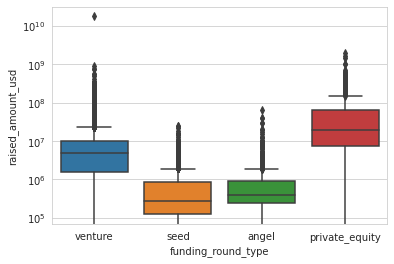

In [94]:
sns.set_style("whitegrid")
sns.boxplot(y=master_frame['raised_amount_usd'], x=master_frame['funding_round_type'])
plt.yscale('log')
plt.show()

### Plot showing the top 9 countries against the total amount of investments of funding type venture

In [95]:
top9['preferrred_country'] = top9.country_code.isin(['USA', 'GBR', 'IND'])

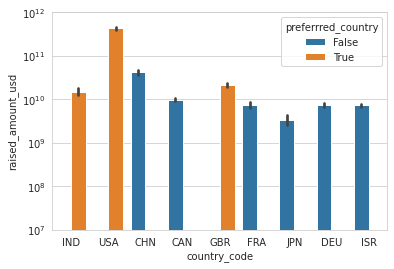

In [96]:
sns.barplot(data=top9, x=top9.country_code, y=top9.raised_amount_usd, estimator=np.sum, hue='preferrred_country')
plt.ylim(10000000, 1000000000000)
plt.yscale('log')
plt.show()

In [97]:
top9.groupby('country_code').raised_amount_usd.sum().sort_values(ascending=False)

country_code
USA    4.305230e+11
CHN    4.185392e+10
GBR    2.119281e+10
IND    1.508651e+10
CAN    9.907218e+09
FRA    7.521851e+09
ISR    7.409350e+09
DEU    7.401922e+09
JPN    3.362647e+09
Name: raised_amount_usd, dtype: float64